# Amazon Fine Food Reviews

https://www.kaggle.com/snap/amazon-fine-food-reviews

## Hyperparameters

In [1]:
hyperparameters = {
    'is_training': True,
}

## Load Dataset

In [2]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.ml.feature import RegexTokenizer
from pyspark.sql.functions import *

df = spark.read.csv("Reviews.csv",header=False, schema=StructType([
    StructField('Id', IntegerType(), True),
    StructField('ProductId', StringType(), True),
    StructField('UserId', StringType(), True),
    StructField('ProfileName', StringType(), True),
    StructField('HelpfulnessNumerator', IntegerType(), True),
    StructField('HelpfulnessDenominator', IntegerType(), True),
    StructField('Score', IntegerType(), True),
    StructField('Time', IntegerType(), True),
    StructField('Summary', StringType(), True),
    StructField('Text', StringType(), True)]))
df = df.select('Id', 'Text', 'Score').limit(10000)
df = df.filter('Id' > 0 and length('Text') > 0).filter(col('Score') > 0)

df.show()

+---+--------------------+-----+
| Id|                Text|Score|
+---+--------------------+-----+
|  1|I have bought sev...|    5|
|  2|"Product arrived ...|    1|
|  3|"This is a confec...|    4|
|  4|If you are lookin...|    2|
|  5|Great taffy at a ...|    5|
|  6|I got a wild hair...|    4|
|  7|This saltwater ta...|    5|
|  8|This taffy is so ...|    5|
|  9|Right now I'm mos...|    5|
| 10|This is a very he...|    5|
| 11|I don't know if i...|    5|
| 12|One of my boys ne...|    5|
| 13|My cats have been...|    1|
| 14|good flavor! thes...|    4|
| 15|The Strawberry Tw...|    5|
| 16|My daughter loves...|    5|
| 17|I love eating the...|    2|
| 18|I am very satisfi...|    5|
| 19|Twizzlers, Strawb...|    5|
| 20|Candy was deliver...|    5|
+---+--------------------+-----+
only showing top 20 rows



## Investigating the Data

min review length (in words) 1
max review length (in words) 1255
average review length (in words) 69.4180524945


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11056c2d0>]],
      dtype=object)

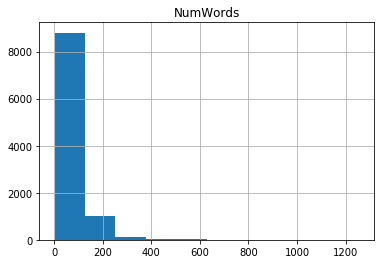

In [3]:
%matplotlib inline

df = RegexTokenizer(inputCol='Text', outputCol='Tokenized', pattern="\\W").transform(df)
df = df.withColumn('NumWords', size('Tokenized'))
# you can see that there are reviews with just one word
print 'min review length (in words)', df.select(min('NumWords')).collect()[0][0]
# you can see that there are reviews with a very high number of words
print 'max review length (in words)', df.select(max('NumWords')).collect()[0][0]
print 'average review length (in words)', df.select(mean('NumWords')).collect()[0][0]

df.select('NumWords').toPandas().hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10cd7e4d0>]],
      dtype=object)

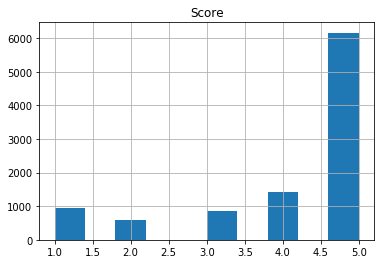

In [4]:
%matplotlib inline

df.select('Score').toPandas().hist(range=[1, 5])

## Cleaning the Data

In [5]:
from pyspark.ml.feature import StopWordsRemover, Word2Vec, NGram, OneHotEncoder, StringIndexer

temp = df.filter(col('Score') == 5)
df = df.filter(col('Score') != 5)
temp = temp.sample(0.2)
df = df.union(temp)

df = StopWordsRemover(inputCol='Tokenized', outputCol='TokenizedStopped').transform(df)
df = df.withColumn('NumWordsStopped', size('TokenizedStopped'))
df = df.filter(col('NumWordsStopped') > 2).filter(col('NumWordsStopped') <= 100)
df = df.withColumn('TextStopped', concat_ws(' ', 'TokenizedStopped'))
# df = StringIndexer(inputCol='TextStopped', outputCol='categoryIndex').fit(df).transform(df)
# df = OneHotEncoder(inputCol='categoryIndex', outputCol='categoryVec').transform(df)
df = Word2Vec(vectorSize=5, seed=42, minCount=0, inputCol='TokenizedStopped', 
              outputCol='Word2Vec').fit(df).transform(df)
df = NGram(n=2, inputCol='TokenizedStopped', outputCol='ngrams').transform(df)

df = df.select('Id', 'Text', 'Score', 'NumWordsStopped', 'TextStopped', 'Word2Vec')

df.show()

+---+--------------------+-----+---------------+--------------------+--------------------+
| Id|                Text|Score|NumWordsStopped|         TextStopped|            Word2Vec|
+---+--------------------+-----+---------------+--------------------+--------------------+
|  2|"Product arrived ...|    1|             18|product arrived l...|[0.09954480018414...|
|  3|"This is a confec...|    4|             31|confection around...|[0.04530252480218...|
|  4|If you are lookin...|    2|             18|looking secret in...|[0.09102239248265...|
|  6|I got a wild hair...|    4|             39|got wild hair taf...|[0.06683626809778...|
| 13|My cats have been...|    1|             40|cats happily eati...|[0.09753783685446...|
| 14|good flavor! thes...|    4|              9|good flavor came ...|[0.02777793744785...|
| 17|I love eating the...|    2|             18|love eating good ...|[0.03869705564445...|
| 27|The candy is just...|    1|              7|candy red flavor ...|[0.07972062485558...|

In [6]:
# import numpy as np
# from sklearn.preprocessing import OneHotEncoder

# enc = OneHotEncoder()
# enc.fit(np.array(df.select('TextStopped').collect()).reshape(-1, 1))
# ar = enc.transform(df.select('TextStopped').collect()).toarray()
# df = df.withColumn('OneHot', enc.transform(col('TextStopped').reshape(-1, 1)).toarray())

## After Cleanup

min review length (in words) 3
max review length (in words) 100
average review length (in words) 32.3414735963


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x112652390>]],
      dtype=object)

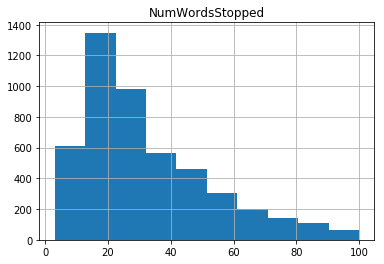

In [7]:
%matplotlib inline

min_words = df.select(min('NumWordsStopped')).collect()[0][0]
print 'min review length (in words)', min_words
max_words = df.select(max('NumWordsStopped')).collect()[0][0]
print 'max review length (in words)', max_words
print 'average review length (in words)', df.select(mean('NumWordsStopped')).collect()[0][0]

df.select('NumWordsStopped').toPandas().hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1102c19d0>]],
      dtype=object)

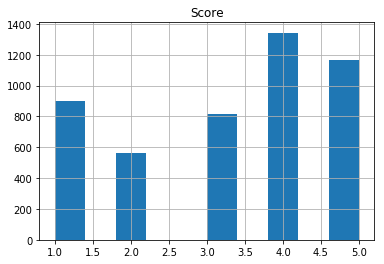

In [8]:
%matplotlib inline

df.select('Score').toPandas().hist(range=[1, 5])

## Feature Engineering

In [9]:
data = [(x[0], float(x[1].toArray().mean())) for x in df.select('Id', 'Word2Vec').collect()]
temp_df = spark.createDataFrame(data, ['Id', 'AverageEmbedding'])
df = df.join(temp_df, df['Id'] == temp_df['Id'])
df = df.drop('Id')
df = df.withColumn('NumWordsStoppedNormalized', (col('NumWordsStopped') - min_words) / (max_words - min_words))
df = df.withColumn('ExclamationPoints', size(split(col('Text'), r'!')) - 1)

df.show()

+--------------------+-----+---------------+--------------------+--------------------+--------------------+-------------------------+-----------------+
|                Text|Score|NumWordsStopped|         TextStopped|            Word2Vec|    AverageEmbedding|NumWordsStoppedNormalized|ExclamationPoints|
+--------------------+-----+---------------+--------------------+--------------------+--------------------+-------------------------+-----------------+
|"Product arrived ...|    1|             18|product arrived l...|[0.09954480018414...| 0.03353120211977511|      0.15463917525773196|                0|
|"This is a confec...|    4|             31|confection around...|[0.04530252480218...|-0.02916573448437...|      0.28865979381443296|                0|
|If you are lookin...|    2|             18|looking secret in...|[0.09102239248265...|-0.02730267998671...|      0.15463917525773196|                0|
|I got a wild hair...|    4|             39|got wild hair taf...|[0.06683626809778...|-0

## Clustering

In [10]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.linalg import Vectors

dataset = df.select('NumWordsStopped', 'Score')
data = [(Vectors.dense([x[0], x[1]]),) for x in dataset.collect()]
dataset = spark.createDataFrame(data, ['features'])
kmeans = KMeans().setK(5).setSeed(1)
model = kmeans.fit(dataset)
predictions = model.transform(dataset)
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.664381326297
Cluster Centers: 
[51.7106274   3.22151088]
[21.60969793  3.31717011]
[78.03671706  3.10799136]
[34.01865672  3.19682836]
[12.14297453  3.44617913]


In [11]:
# %matplotlib inline

# import matplotlib.pyplot as plt

# # plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

# centers = model.clusterCenters()
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

## Classification

In [12]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

dataset = df.select('NumWordsStoppedNormalized', 'AverageEmbedding', 
                    'ExclamationPoints', 'Score').orderBy(rand())
# dataset = df.select('Word2Vec', 'Score')
data = [(x[3], Vectors.dense([x[0], x[1], x[2]])) for x in dataset.collect()]
# data = [(x[1], x[0]) for x in dataset.collect()]
dataset = spark.createDataFrame(data, ['label', 'features'])
labelIndexer = StringIndexer(inputCol='label', outputCol='indexedLabel').fit(dataset)
featureIndexer = VectorIndexer(inputCol="features", outputCol='indexedFeatures', maxCategories=5).fit(dataset)
(trainingData, testData) = dataset.randomSplit([0.7, 0.3])
rf = RandomForestClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures', numTrees=10)
labelConverter = IndexToString(inputCol='prediction', outputCol='predictedLabel',
                               labels=labelIndexer.labels)
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])
model = pipeline.fit(trainingData)
predictions = model.transform(testData)
evaluator = MulticlassClassificationEvaluator(labelCol='indexedLabel', 
                                              predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g " % (1.0 - accuracy))
predictions.select('predictedLabel', 'label', 'features').show()

Test Error = 0.655221 
+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|             4|    1|[0.0,-0.066677582...|
|             4|    1|[0.05154639175257...|
|             4|    1|[0.07216494845360...|
|             4|    1|[0.11340206185567...|
|             4|    1|[0.12371134020618...|
|             4|    1|[0.12371134020618...|
|             4|    1|[0.14432989690721...|
|             5|    1|[0.14432989690721...|
|             5|    1|[0.15463917525773...|
|             4|    1|[0.15463917525773...|
|             5|    1|[0.15463917525773...|
|             4|    1|[0.16494845360824...|
|             5|    1|[0.17525773195876...|
|             5|    1|[0.19587628865979...|
|             5|    1|[0.19587628865979...|
|             1|    1|[0.19587628865979...|
|             5|    1|[0.20618556701030...|
|             1|    1|[0.20618556701030...|
|             5|    1|[0.21649484536082...|
|        

## Evaluation

In [13]:
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics

predictionAndLabels = sc.parallelize([(float(x[0]), float(x[1])) 
                                      for x in predictions.select('predictedLabel', 'label').collect()])
metrics = MulticlassMetrics(predictionAndLabels)
print("Summary Stats")
print('Accuracy = %s' % metrics.accuracy)
print("Precision = %s" % metrics.precision())
print("Recall = %s" % metrics.recall())
print("F1 Score = %s" % metrics.fMeasure())
for label in [float(x) for x in range(1, 6)]:
    print("Class %s precision = %s" % (label, metrics.precision(label)))
    print("Class %s recall = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))
print("Weighted recall = %s" % metrics.weightedRecall)
print("Weighted precision = %s" % metrics.weightedPrecision)
print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)

Summary Stats
Accuracy = 0.344779257183
Precision = 0.344779257183
Recall = 0.344779257183
F1 Score = 0.344779257183
Class 1.0 precision = 0.346456692913
Class 1.0 recall = 0.177419354839
Class 1.0 F1 Measure = 0.234666666667
Class 2.0 precision = 0.0
Class 2.0 recall = 0.0
Class 2.0 F1 Measure = 0.0
Class 3.0 precision = 0.181818181818
Class 3.0 recall = 0.0084388185654
Class 3.0 F1 Measure = 0.0161290322581
Class 4.0 precision = 0.316384180791
Class 4.0 recall = 0.696517412935
Class 4.0 F1 Measure = 0.43512043512
Class 5.0 precision = 0.410891089109
Class 5.0 recall = 0.448648648649
Class 5.0 F1 Measure = 0.428940568475
Weighted recall = 0.344779257183
Weighted precision = 0.286074500758
Weighted F(1) Score = 0.277257420626
Weighted F(0.5) Score = 0.264895634399
Weighted false positive rate = 0.238150390664
